## Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

## Exploring Fake News

In [3]:
fake = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv')

In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
fake.shape

(23481, 4)

In [6]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [7]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

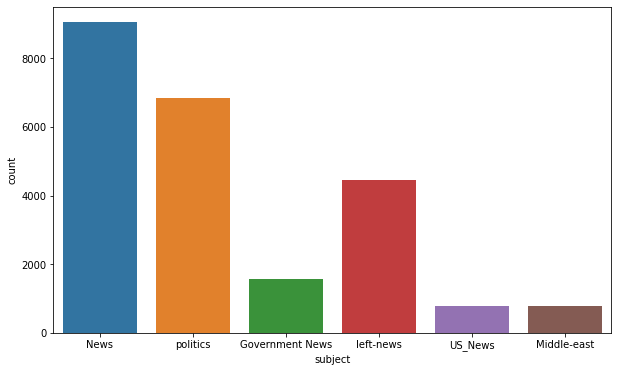

In [8]:
plt.figure(figsize=(10,6))
sns.countplot('subject', data=fake)

## Wordcloud

In [9]:
text = ' '.join(fake['text'].tolist())

In [10]:
text[:200]

'Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former rea'

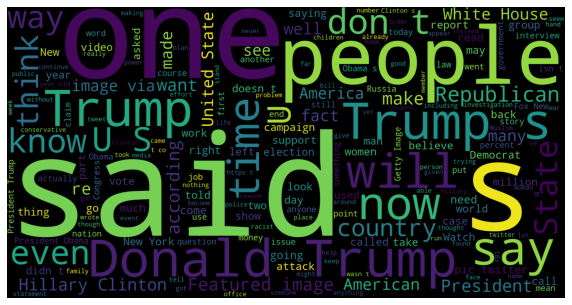

In [11]:
wordcloud = WordCloud(width=1920, height=1000).generate(text)
plt.figure(figsize=(10,20))
plt.axis('off')
plt.imshow(wordcloud)

## Exploring Real News

In [12]:
real = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv')

In [13]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [14]:
real.shape

(21417, 4)

In [15]:
text = ' '.join(real['text'].tolist())

In [16]:
text[:100]

'WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted'

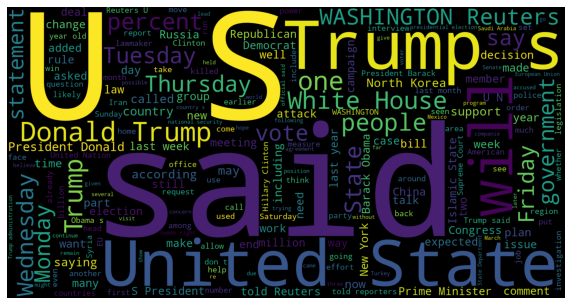

In [17]:
wordcloud = WordCloud(width=1920, height=1000).generate(text)
plt.figure(figsize=(10,20))
plt.axis('off')
plt.imshow(wordcloud)

## Cleaning Data

In [18]:
real.sample(5)

,title,text,subject,date
4051,The Reuters Graphic: North Korea's show of force,(Reuters) - North Korea’s latest display of it...,politicsNews,"April 27, 2017"
17165,"Kosovo urges U.S. involvement in Belgrade, Pri...",(This version of the October 15 story correct...,worldnews,"October 16, 2017"
16889,France to give 15 million euros in aid for Syr...,PARIS (Reuters) - France will provide 15 milli...,worldnews,"October 20, 2017"
10290,Sergeant Bergdahl says 'fantastic' plan crumbl...,(Reuters) - U.S. Army Sergeant Bowe Bergdahl h...,politicsNews,"March 17, 2016"
19836,"Turkey's Erdogan, Iraq's Abadi to discuss Iraq...",ANKARA (Reuters) - Turkish President Tayyip Er...,worldnews,"September 17, 2017"


In [19]:
unknown_publishers = []
for index, row in enumerate(real.text.values):
  try:
    record = row.split('-', maxsplit=1)
    record[1]

    assert(len(record[0])<120)
  except:
    unknown_publishers.append(index)

In [20]:
len(unknown_publishers)

222

In [21]:
real.iloc[8970].text

' '

In [22]:
real = real.drop(8970, axis=0)

In [23]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20136    LIMA (Reuters) - The government of Peru s Pres...
20501    BEIJING (Reuters) - Chinese importers of forei...
20668    (Reuters) - Hurricane Irma, one of the most po...
21247    LONDON (Reuters) - Princes William and Harry p...
21340    LONDON (Reuters) - Britain will pay  not a pen...
Name: text, Length: 222, dtype: object

In [24]:
publisher = []
tmp_text = []

for index, row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')
    continue

  else:
    record = row.split('-', maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [25]:
real['publisher'] = publisher
real['text'] = tmp_text

In [26]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [27]:
real.shape

(21416, 5)

In [28]:
empty_fake_index = [index for index, text in enumerate(fake.text.tolist()) if str(text).strip()=='']

In [29]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [30]:
real['text'] = real['title'] + " " + real['text']
fake['text'] = fake['title'] + " " + fake['text']

In [31]:
real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

## Preprocessing Text

In [32]:
real['class'] = 1
fake['class'] = 0

In [33]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [34]:
real = real[['text', 'class']]
fake = fake[['text', 'class']]

In [35]:
data = real.append(fake, ignore_index=False)

In [36]:
data.head(5)

,text,class
0,"as u.s. budget fight looms, republicans flip t...",1
1,u.s. military to accept transgender recruits o...,1
2,senior u.s. republican senator: 'let mr. muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1


In [37]:
data['text'].apply(lambda x: x.replace('.','')).head()

0    as us budget fight looms, republicans flip the...
1    us military to accept transgender recruits on ...
2    senior us republican senator: 'let mr mueller ...
3    fbi russia probe helped by australian diplomat...
4    trump wants postal service to charge 'much mor...
Name: text, dtype: object

In [38]:
data['text'] = data['text'].apply(lambda x: x.replace('.',''))
data['text'] = data['text'].apply(lambda x: re.sub('\W+',' ', x))

In [39]:
data['text'].head()

0    as us budget fight looms republicans flip thei...
1    us military to accept transgender recruits on ...
2    senior us republican senator let mr mueller do...
3    fbi russia probe helped by australian diplomat...
4    trump wants postal service to charge much more...
Name: text, dtype: object

In [40]:
data.head()

,text,class
0,as us budget fight looms republicans flip thei...,1
1,us military to accept transgender recruits on ...,1
2,senior us republican senator let mr mueller do...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge much more...,1


## Vectorization - Word2Vec

In [116]:
import gensim

In [117]:
y = data['class'].values

In [118]:
X = [d.split() for d in data['text'].tolist()]

In [119]:
type(X[0])

list

In [120]:
print(X[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues',

In [121]:
DIM = 100

w2v_model = gensim.models.Word2Vec(sentences=X, size=DIM, window=10, min_count=1)

In [122]:
len(w2v_model.wv.vocab)

187856

In [123]:
w2v_model.wv['love']

array([ 1.4047403 ,  2.0539277 ,  1.9472499 , -1.2011944 ,  0.23195842,
        1.0958709 , -3.0761635 ,  0.09518193, -1.5526223 ,  2.4760783 ,
        0.892036  , -1.167022  ,  2.1025374 , -0.02728022, -2.9022589 ,
       -0.4520331 , -1.0442497 , -2.0434098 ,  0.21831542,  1.7220552 ,
       -0.08969468, -0.23074195,  0.12207162, -1.9123385 ,  0.81979054,
       -0.31593922, -0.25009936, -4.97205   , -0.7629717 ,  0.2569267 ,
        2.1508303 ,  1.7771821 , -0.21365209, -0.52978003, -2.4032738 ,
        3.257982  ,  2.2471905 ,  0.785949  ,  2.631328  ,  0.05344696,
       -1.9571277 , -0.2895678 , -0.7748974 ,  3.085248  ,  1.1937962 ,
        1.4456613 , -3.6617794 ,  4.9986825 ,  0.9077275 ,  1.2908928 ,
        2.7020714 , -2.7608402 ,  2.961715  , -2.1032531 ,  1.3604373 ,
       -0.01441202, -0.49786797, -0.72216904, -1.8809618 ,  2.3558981 ,
        0.3079832 ,  1.9929943 , -2.466895  , -2.4617815 , -1.6286738 ,
       -3.2130327 ,  1.7023914 , -0.8117595 ,  1.2784859 , -0.08

In [124]:
len(w2v_model.wv['india']) ## From DIM = 100

100

In [125]:
w2v_model.wv.most_similar('india')

[('pakistan', 0.730498731136322),
 ('malaysia', 0.6735684275627136),
 ('modi', 0.6481291055679321),
 ('indian', 0.6397271156311035),
 ('china', 0.620970606803894),
 ('narendra', 0.6061892509460449),
 ('philippines', 0.6005505323410034),
 ('australia', 0.5917475819587708),
 ('singapore', 0.576592743396759),
 ('islamabad', 0.5758286118507385)]

In [126]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [127]:
X = tokenizer.texts_to_sequences(X)

In [128]:
# tokenizer.word_index

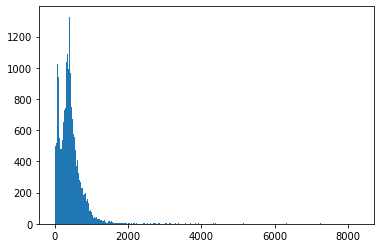

In [129]:
plt.hist([len(x) for x in X], bins=700)
plt.show()

In [130]:
nos = np.array([len(x) for x in X])
len(nos[nos>1000])

1717

In [131]:
maxlen = 1000
X = pad_sequences(X, maxlen=maxlen)

In [132]:
len(X[10])

1000

In [133]:
len(X)

44897

In [134]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [135]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM))

  for word, i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix

In [136]:
embedding_vectors = get_weight_matrix(w2v_model)

In [137]:
embedding_vectors.shape

(187857, 100)

In [138]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [139]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         18785700  
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 18,903,077
Trainable params: 117,377
Non-trainable params: 18,785,700
_________________________________________________________________


In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [141]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
737/737 [==============================] - 39s 51ms/step - loss: 0.1414 - accuracy: 0.9490 - val_loss: 0.0974 - val_accuracy: 0.9703
Epoch 2/6
737/737 [==============================] - 37s 50ms/step - loss: 0.0693 - accuracy: 0.9771 - val_loss: 0.0808 - val_accuracy: 0.9748
Epoch 3/6
737/737 [==============================] - 38s 51ms/step - loss: 0.0401 - accuracy: 0.9868 - val_loss: 0.0383 - val_accuracy: 0.9883
Epoch 4/6
737/737 [==============================] - 48s 65ms/step - loss: 0.0240 - accuracy: 0.9921 - val_loss: 0.0294 - val_accuracy: 0.9900
Epoch 5/6
737/737 [==============================] - 40s 55ms/step - loss: 0.0143 - accuracy: 0.9952 - val_loss: 0.0423 - val_accuracy: 0.9865
Epoch 6/6
737/737 [==============================] - 38s 52ms/step - loss: 0.0110 - accuracy: 0.9962 - val_loss: 0.0320 - val_accuracy: 0.9891


In [142]:
y_pred = (model.predict(X_test) >= 0.5).astype(int) 

351/351 [==============================] - 7s 18ms/step


In [68]:
accuracy_score(y_pred, y_test)  

0.9902895322939866

In [69]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5908
           1       0.99      0.99      0.99      5317

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [70]:
x = ['this is a news']

In [71]:
X_test

array([[     0,      0,      0, ...,   1292,     13,     15],
       [     0,      0,      0, ...,   3350,      6,   1461],
       [     0,      0,      0, ...,     11,      4,   4168],
       ...,
       [     0,      0,      0, ...,    567,      3,    190],
       [     0,      0,      0, ...,    200,     25, 168602],
       [     0,      0,      0, ...,     71,     51,     15]], dtype=int32)

In [72]:
x = tokenizer.texts_to_sequences(x)
x

[[26, 11, 4, 96]]

In [73]:
x = pad_sequences(x, maxlen=maxlen)
x

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

In [74]:
(model.predict(x) >= 0.5).astype(int) # 0 means it's a fake news

1/1 [==============================] - 0s 50ms/step


array([[0]])

In [191]:
def test(x):
  x = tokenizer.texts_to_sequences(x)
  x = pad_sequences(x, maxlen=maxlen)
  pred = (model.predict(x) >= 0.5).astype(int) 
  if(pred[0][0]==0):
    print('It is fake news')
  else:
    print('It is real news')

In [193]:
test(['this is a news'])

1/1 [==============================] - 0s 42ms/step
It is fake news


In [194]:
test(['New Omicron Covid-19 variants that experts say appears to spread easily are on the rise in the US, a report said quoting the latest federal data. Emphasizing on how the variants could present new risks, Wall Street Journal reported that according to the Centers for Disease Control and Prevention (CDC) estimates released on Friday, the two Omicron subvariants BQ.1 and BQ.1.1 could represent a combined 11.4% of US Covid infections by mid-October.'])

1/1 [==============================] - 0s 42ms/step
It is real news


In [195]:
test(['Former Punjab industries and commerce minister, Sunder Sham Arora was arrested on Saturday night while attempting to bribe an assistant inspector general of the vigilance bureau in Zirakpur, a senior officer of the agency said on Sunday.'])

1/1 [==============================] - 0s 41ms/step
It is real news


In [196]:
test(['This is not a news'])

1/1 [==============================] - 0s 45ms/step
It is fake news


In [200]:
test(['Misbah-ul-Haqs reverse lap off Joginder Sharmas delivery that had landed safely into the hands of Sreesanth in the 2007 T20 World Cup is a memory deeply embedded in the memory of most cricket fans of both India and Pakistan. That one very moment had agony and ecstasy written all over - a moment to savour for the young Indian side under MS Dhoni and a moment to forget for Pakistan, especially for Misbah. Fifteen years hence, the veteran Pakistan batter, who had retired form the game as one of the greats of Pakistan cricket, still regrets having played that shot and rather had a cracking response on it when the legendary Wasim Akram asked him a million dollar question.'])

1/1 [==============================] - 0s 98ms/step
It is real news
